# Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали.

Необходимо построить модель, которая предскажет температуру стали после обработки. Это позволит не запускать заранее убыточный процесс.

## Загрузка данных


In [ ]:
!pip install catboost==1.0.3 \
             optuna==3.3.0 \
             tqdm==4.66.1

In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor
import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, \
                                 FloatDistribution, \
                                 CategoricalDistribution
from tqdm.notebook import tqdm
import warnings
from catboost import CatBoostRegressor

In [ ]:
warnings.simplefilter('ignore', optuna.exceptions.ExperimentalWarning)
warnings.simplefilter('ignore', FutureWarning)
optuna.logging.set_verbosity('ERROR')

In [ ]:
RNG_SEED = 310723

In [ ]:
if Path('/content').is_dir():
    %cd /content
!mkdir -p data
%cd data
!wget -qN https://code.s3.yandex.net/datasets/data_arc_new.csv \
          https://code.s3.yandex.net/datasets/data_bulk_new.csv \
          https://code.s3.yandex.net/datasets/data_bulk_time_new.csv \
          https://code.s3.yandex.net/datasets/data_gas_new.csv \
          https://code.s3.yandex.net/datasets/data_temp_new.csv \
          https://code.s3.yandex.net/datasets/data_wire_new.csv \
          https://code.s3.yandex.net/datasets/data_wire_time_new.csv
%cd ..

/content
/content/data
/content


In [ ]:
files = sorted(Path('data').iterdir())
data = [pd.read_csv(f) for f in files]
files = [f.name for f in files]

## Исследовательский анализ

In [ ]:
def info(x, basic=True, dist=True, **hist_kwargs):
    df = data[x]
    f = files[x]
    l = 80
    print(f'{f" {f} ":=^{l}}')
    if basic:
        print(f'|{" Basic info ":-^{l-2}}|')
        df.info()
        display(df[:5])
    if dist:
        print(f'|{" Distribution ":-^{l-2}}|')
        _df = df.drop(['key'], axis=1)
        display(_df.describe())
        _df.hist(bins=50, **hist_kwargs)
        plt.tight_layout()
        plt.show()
        del _df

=============================== data_arc_new.csv ===============================
|--------------------------------- Basic info ---------------------------------|
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


|-------------------------------- Distribution --------------------------------|


,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000
mean,0.662752,0.438986
std,0.258885,5.873485
min,0.223120,-715.479924
25%,0.467115,0.337175
50%,0.599587,0.441639
75%,0.830070,0.608201
max,1.463773,1.270284


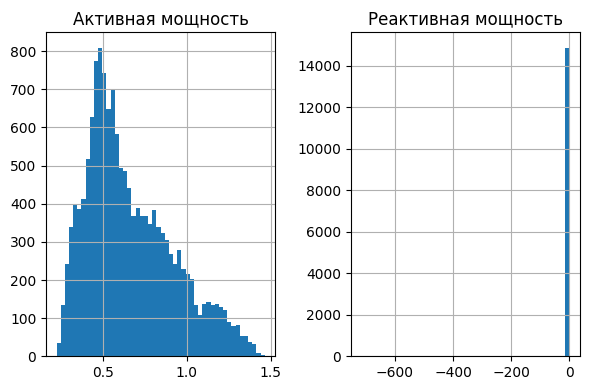

In [ ]:
info(0, figsize=(6, 4))

Пропусков нет.
В столбце с реактивной мощностью есть аномальные отрицательные значения

============================== data_bulk_new.csv ===============================
|--------------------------------- Basic info ---------------------------------|
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


|-------------------------------- Distribution --------------------------------|


,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


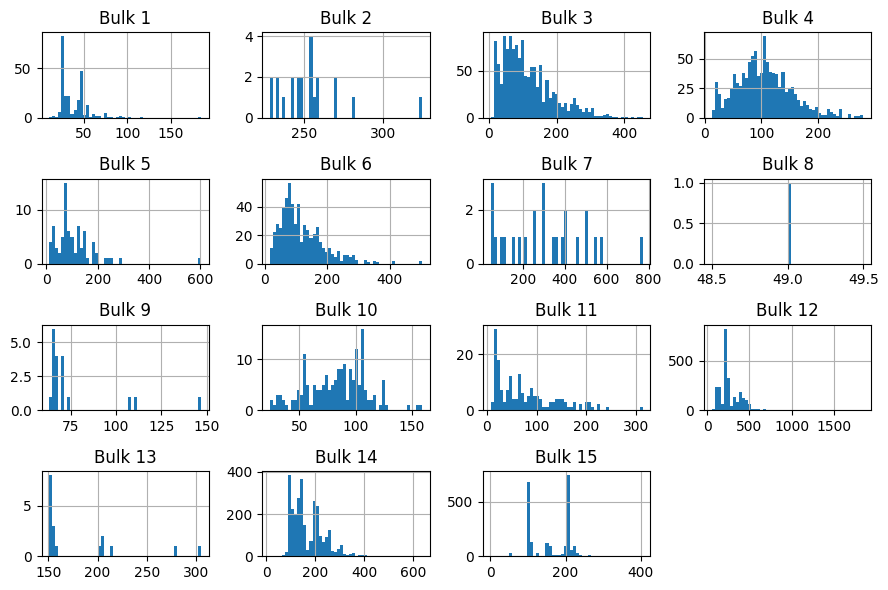

In [ ]:
info(1, figsize=(9, 6))

Пропуски нужно заполнить 0 по ТЗ. В столбце Bulk 8 всего 1 значение, поэтому это неинформативный признак.

In [ ]:
info(2, dist=False)

============================ data_bulk_time_new.csv ============================
|--------------------------------- Basic info ---------------------------------|
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


Здесь только даты в таком же количестве как и в предыдущей таблице. В итоговой таблице они не нужны.

=============================== data_gas_new.csv ===============================
|--------------------------------- Basic info ---------------------------------|
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


|-------------------------------- Distribution --------------------------------|


,Газ 1
count,3239.000000
mean,11.002062
std,6.220327
min,0.008399
25%,7.043089
50%,9.836267
75%,13.769915
max,77.995040


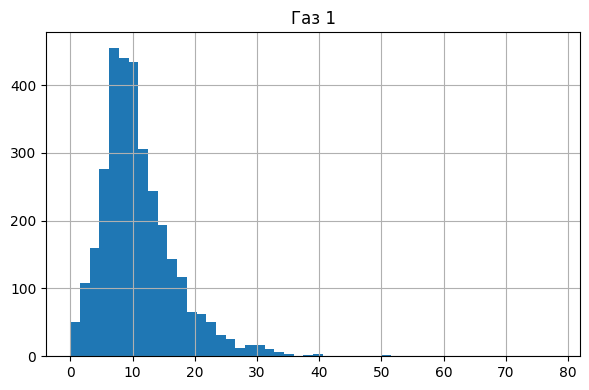

In [ ]:
info(3, figsize=(6, 4))

Пропусков нет. Выбросы здесь это значения примерно большие 35.

============================== data_temp_new.csv ===============================
|--------------------------------- Basic info ---------------------------------|
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


|-------------------------------- Distribution --------------------------------|


,Температура
count,14665.000000
mean,1590.722741
std,20.394381
min,1191.000000
25%,1580.000000
50%,1590.000000
75%,1599.000000
max,1705.000000


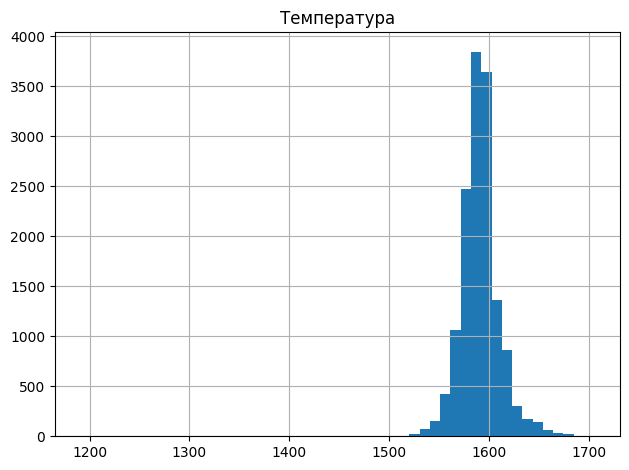

In [ ]:
info(4)

Есть несколько пропусков температуры, что скорее всего означает что замеры в это время не проводились.
Также присутствуют аномально низкие значения температуры, ниже средней температуры плавления стали ≈ 1500 °C.

============================== data_wire_new.csv ===============================
|--------------------------------- Basic info ---------------------------------|
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


|-------------------------------- Distribution --------------------------------|


,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


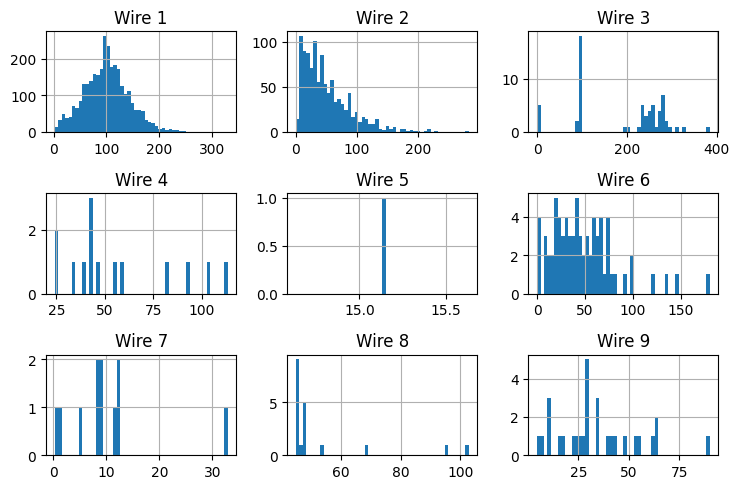

In [ ]:
info(5, figsize=(7.5, 5))

Пропуски заполняются 0 по ТЗ. Wire 5 можно удалить, т.к. там всего 1 значение.

In [ ]:
info(6, dist=False)

============================ data_wire_time_new.csv ============================
|--------------------------------- Basic info ---------------------------------|
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Здесь только даты в таком же количестве как и в предыдущей таблице. В итоговой таблице они не нужны.

Вывод:
- Проанализированны пропущенные значения
- Изучено распределение данных в таблицах
- Исследованны аномалии в данных
- Оценена важность признаков для обучения моделей

## План работы
1. Провести предобработку данных
1. Объединить данные в единую таблицу
1. Провести анализ объединённого датафрейма
1. Обучить различные модели регресси на кросс-валидации и выбрать среди них лучшую
1. Проверить лучшую модель на тестовой выборке и сравнить её с дамми моделью
1. Написать вывод по итогам тестирования
1. Написать отчёт по проекту

## Предобработка данных

Переводим время нагрева в datetime и удаляем отрицательную мощность

=============================== data_arc_new.csv ===============================
|--------------------------------- Basic info ---------------------------------|
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14875 non-null  int64         
 1   start_time      14875 non-null  datetime64[ns]
 2   end_time        14875 non-null  datetime64[ns]
 3   active_power    14875 non-null  float64       
 4   reactive_power  14875 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.3 KB


,key,start_time,end_time,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


|-------------------------------- Distribution --------------------------------|


,active_power,reactive_power
count,14875.000000,14875.000000
mean,0.662749,0.487115
std,0.258894,0.197612
min,0.223120,0.153777
25%,0.467115,0.337190
50%,0.599578,0.441665
75%,0.830135,0.608223
max,1.463773,1.270284


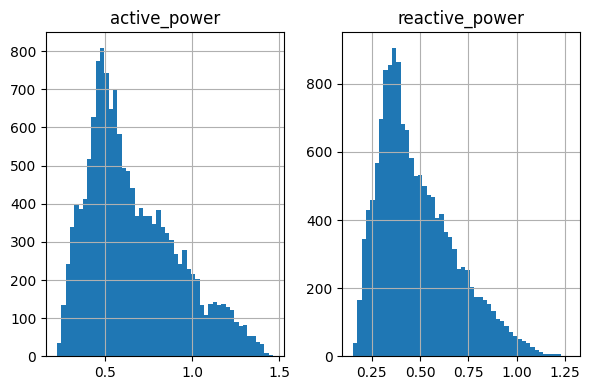

In [ ]:
data[0] = (data[0]
           .set_axis(['key',
                      'start_time',
                      'end_time',
                      'active_power',
                      'reactive_power'],
                     axis=1)
           .astype({'start_time': 'datetime64[ns]',
                    'end_time': 'datetime64[ns]'})
           [lambda x: x.reactive_power > 0])
info(0, column=['active_power', 'reactive_power'], figsize=(6, 4))

Удаляем столбцы где пропусков больше 80% и заполняем остальные пропуски нулями

============================== data_bulk_new.csv ===============================
|--------------------------------- Basic info ---------------------------------|
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_3   3129 non-null   float64
 2   bulk_4   3129 non-null   float64
 3   bulk_12  3129 non-null   float64
 4   bulk_14  3129 non-null   float64
 5   bulk_15  3129 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 146.8 KB


,key,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15
0,1,0.0,43.0,206.0,150.0,154.0
1,2,0.0,73.0,206.0,149.0,154.0
2,3,0.0,34.0,205.0,152.0,153.0
3,4,0.0,81.0,207.0,153.0,154.0
4,5,0.0,78.0,203.0,151.0,152.0


|-------------------------------- Distribution --------------------------------|


,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,47.240332,33.830617,203.948226,152.706616,115.319271
std,74.239954,56.034505,151.419639,81.091421,84.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,105.000000,104.000000,0.000000
50%,0.000000,0.000000,206.000000,148.000000,106.000000
75%,80.000000,68.000000,263.000000,202.000000,204.000000
max,454.000000,281.000000,1849.000000,636.000000,405.000000


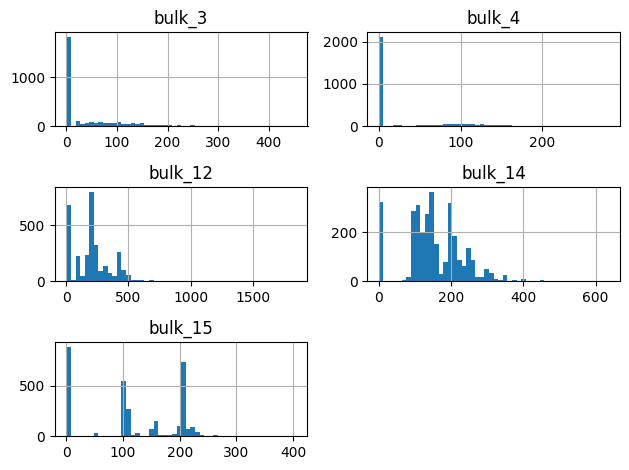

In [ ]:
data[1] = (data[1]
           .rename(lambda s: s.replace(' ', '_').lower(), axis=1)
           .loc[:, lambda x: x.isna().mean() < 0.8]
           .fillna(0))
info(1)

=============================== data_gas_new.csv ===============================
|--------------------------------- Basic info ---------------------------------|
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


|-------------------------------- Distribution --------------------------------|


,gas
count,3239.000000
mean,11.002062
std,6.220327
min,0.008399
25%,7.043089
50%,9.836267
75%,13.769915
max,77.995040


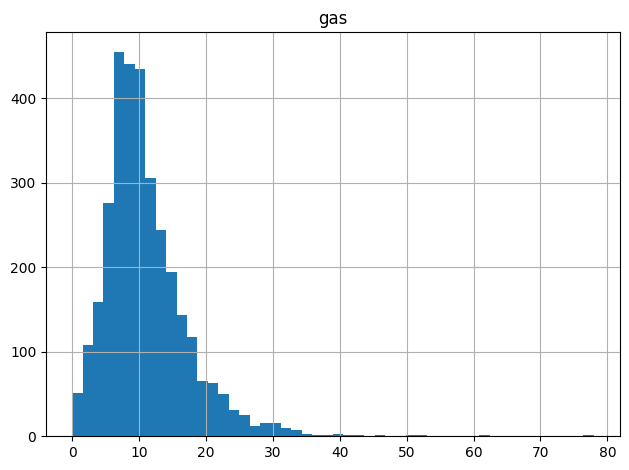

In [ ]:
data[3] = data[3].set_axis(['key', 'gas'], axis=1)
info(3)

Переводим время замера температуры в datetime. Также удаляем ключи которые встречаются только 1 раз и температуры меньше 1500

============================== data_temp_new.csv ===============================
|--------------------------------- Basic info ---------------------------------|
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13920 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   key        13920 non-null  int64         
 1   temp_time  13920 non-null  datetime64[ns]
 2   temp       13920 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 435.0 KB


,key,temp_time,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


|-------------------------------- Distribution --------------------------------|


,temp
count,13920.000000
mean,1590.911494
std,18.774355
min,1515.000000
25%,1580.000000
50%,1590.000000
75%,1599.000000
max,1705.000000


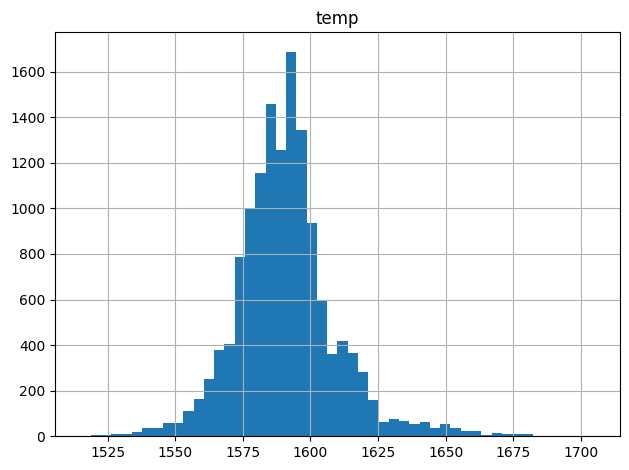

In [ ]:
data[4] = (data[4]
           .set_axis(['key', 'temp_time', 'temp'], axis=1)
           .astype({'temp_time': 'datetime64[ns]'})
           .dropna()
           [lambda x: x.duplicated('key', False) & (x.temp > 1500)])
info(4, column=['temp'])

Удаляем столбцы где пропусков больше 80% и заполняем остальные пропуски нулями

============================== data_wire_new.csv ===============================
|--------------------------------- Basic info ---------------------------------|
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 72.3 KB


,key,wire_1,wire_2
0,1,60.059998,0.00000
1,2,96.052315,0.00000
2,3,91.160157,0.00000
3,4,89.063515,0.00000
4,5,89.238236,9.11456


|-------------------------------- Distribution --------------------------------|


,wire_1,wire_2
count,3081.000000,3081.000000
mean,100.044411,17.712733
std,42.841120,33.517734
min,0.000000,0.000000
25%,70.281120,0.000000
50%,100.114563,0.000000
75%,125.798405,23.162880
max,330.314424,282.780152


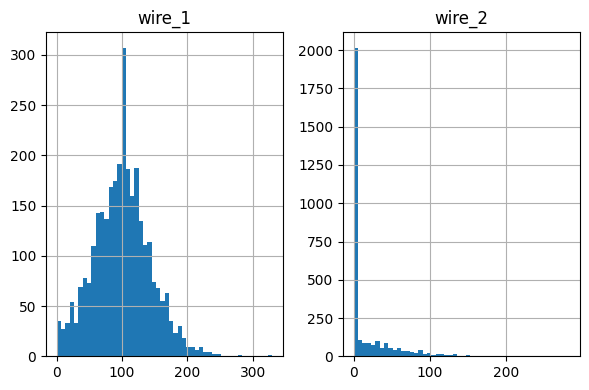

In [ ]:
data[5] = (data[5]
           .rename(lambda s: s.replace(' ', '_').lower(), axis=1)
           .loc[:, lambda x: x.isna().mean() < 0.8]
           .fillna(0))
info(5, figsize=(6, 4))

## Объединение таблиц

In [ ]:
df = (data[0]
      .assign(heating_time=lambda x: (x.end_time - x.start_time).dt.total_seconds())
      .drop(['start_time', 'end_time'], axis=1)
      .groupby('key')
      .agg({'active_power': ['median', 'mean'],
            'reactive_power': ['median', 'mean'],
            'heating_time': ['median', 'mean']})
      .set_axis(['active_med', 'active_mean',
                 'reactive_med', 'reactive_mean',
                 'heating_med', 'heating_mean'],
                axis=1))
df.info()
df[:5]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   active_med     3214 non-null   float64        
 1   active_mean    3214 non-null   float64        
 2   reactive_med   3214 non-null   float64        
 3   reactive_mean  3214 non-null   float64        
 4   heating_med    3214 non-null   timedelta64[ns]
 5   heating_mean   3214 non-null   timedelta64[ns]
dtypes: float64(4), timedelta64[ns](2)
memory usage: 175.8 KB


,active_med,active_mean,reactive_med,reactive_mean,heating_med,heating_mean
key,,,,,,
1,0.580313,0.607346,0.430460,0.428564,0 days 00:03:05,0 days 00:03:39.600000
2,0.545710,0.534852,0.352656,0.363339,0 days 00:02:53.500000,0 days 00:03:22.750000
3,0.774632,0.812728,0.505690,0.587491,0 days 00:01:49,0 days 00:02:11
4,0.753970,0.676622,0.580275,0.514248,0 days 00:03:02,0 days 00:03:05.250000
5,0.517715,0.563238,0.374041,0.421998,0 days 00:03:11.500000,0 days 00:03:37.250000


In [ ]:
df = df.join(data[1].set_index('key'), how='inner')
df.info()
df[:5]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3128 entries, 1 to 3241
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   active_med     3128 non-null   float64        
 1   active_mean    3128 non-null   float64        
 2   reactive_med   3128 non-null   float64        
 3   reactive_mean  3128 non-null   float64        
 4   heating_med    3128 non-null   timedelta64[ns]
 5   heating_mean   3128 non-null   timedelta64[ns]
 6   bulk_3         3128 non-null   float64        
 7   bulk_4         3128 non-null   float64        
 8   bulk_12        3128 non-null   float64        
 9   bulk_14        3128 non-null   float64        
 10  bulk_15        3128 non-null   float64        
dtypes: float64(9), timedelta64[ns](2)
memory usage: 293.2 KB


,active_med,active_mean,reactive_med,reactive_mean,heating_med,heating_mean,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15
key,,,,,,,,,,,
1,0.580313,0.607346,0.430460,0.428564,0 days 00:03:05,0 days 00:03:39.600000,0.0,43.0,206.0,150.0,154.0
2,0.545710,0.534852,0.352656,0.363339,0 days 00:02:53.500000,0 days 00:03:22.750000,0.0,73.0,206.0,149.0,154.0
3,0.774632,0.812728,0.505690,0.587491,0 days 00:01:49,0 days 00:02:11,0.0,34.0,205.0,152.0,153.0
4,0.753970,0.676622,0.580275,0.514248,0 days 00:03:02,0 days 00:03:05.250000,0.0,81.0,207.0,153.0,154.0
5,0.517715,0.563238,0.374041,0.421998,0 days 00:03:11.500000,0 days 00:03:37.250000,0.0,78.0,203.0,151.0,152.0


In [ ]:
df = df.join(data[3].set_index('key'), how='inner')
df.info()
df[:5]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3126 entries, 1 to 3241
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   active_med     3126 non-null   float64        
 1   active_mean    3126 non-null   float64        
 2   reactive_med   3126 non-null   float64        
 3   reactive_mean  3126 non-null   float64        
 4   heating_med    3126 non-null   timedelta64[ns]
 5   heating_mean   3126 non-null   timedelta64[ns]
 6   bulk_3         3126 non-null   float64        
 7   bulk_4         3126 non-null   float64        
 8   bulk_12        3126 non-null   float64        
 9   bulk_14        3126 non-null   float64        
 10  bulk_15        3126 non-null   float64        
 11  gas            3126 non-null   float64        
dtypes: float64(10), timedelta64[ns](2)
memory usage: 317.5 KB


,active_med,active_mean,reactive_med,reactive_mean,heating_med,heating_mean,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,gas
key,,,,,,,,,,,,
1,0.580313,0.607346,0.430460,0.428564,0 days 00:03:05,0 days 00:03:39.600000,0.0,43.0,206.0,150.0,154.0,29.749986
2,0.545710,0.534852,0.352656,0.363339,0 days 00:02:53.500000,0 days 00:03:22.750000,0.0,73.0,206.0,149.0,154.0,12.555561
3,0.774632,0.812728,0.505690,0.587491,0 days 00:01:49,0 days 00:02:11,0.0,34.0,205.0,152.0,153.0,28.554793
4,0.753970,0.676622,0.580275,0.514248,0 days 00:03:02,0 days 00:03:05.250000,0.0,81.0,207.0,153.0,154.0,18.841219
5,0.517715,0.563238,0.374041,0.421998,0 days 00:03:11.500000,0 days 00:03:37.250000,0.0,78.0,203.0,151.0,152.0,5.413692


In [ ]:
df = (df
      .join(data[4]
            .loc[lambda x: x.groupby('key')['temp_time'].idxmin()]
            .set_axis(['key', 'init_time', 'init_temp'], axis=1)
            .set_index('key'),
            how='inner')
      .join(data[4]
            .loc[lambda x: x.groupby('key')['temp_time'].idxmax()]
            .set_axis(['key', 'final_time', 'final_temp'], axis=1)
            .set_index('key'),
            how='inner')
      .assign(temp_time=lambda x: (x.final_time - x.init_time).dt.total_seconds())
      .drop(['init_time', 'final_time'], axis=1))
df.info()
df[:5]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2405 entries, 1 to 2499
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   active_med     2405 non-null   float64        
 1   active_mean    2405 non-null   float64        
 2   reactive_med   2405 non-null   float64        
 3   reactive_mean  2405 non-null   float64        
 4   heating_med    2405 non-null   timedelta64[ns]
 5   heating_mean   2405 non-null   timedelta64[ns]
 6   bulk_3         2405 non-null   float64        
 7   bulk_4         2405 non-null   float64        
 8   bulk_12        2405 non-null   float64        
 9   bulk_14        2405 non-null   float64        
 10  bulk_15        2405 non-null   float64        
 11  gas            2405 non-null   float64        
 12  init_temp      2405 non-null   float64        
 13  final_temp     2405 non-null   float64        
 14  temp_time      2405 non-null   timedelta64[ns]
dtypes: f

,active_med,active_mean,reactive_med,reactive_mean,heating_med,heating_mean,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,gas,init_temp,final_temp,temp_time
key,,,,,,,,,,,,,,,
1,0.580313,0.607346,0.430460,0.428564,0 days 00:03:05,0 days 00:03:39.600000,0.0,43.0,206.0,150.0,154.0,29.749986,1571.0,1613.0,0 days 00:28:34
2,0.545710,0.534852,0.352656,0.363339,0 days 00:02:53.500000,0 days 00:03:22.750000,0.0,73.0,206.0,149.0,154.0,12.555561,1581.0,1602.0,0 days 00:21:05
3,0.774632,0.812728,0.505690,0.587491,0 days 00:01:49,0 days 00:02:11,0.0,34.0,205.0,152.0,153.0,28.554793,1596.0,1599.0,0 days 00:29:13
4,0.753970,0.676622,0.580275,0.514248,0 days 00:03:02,0 days 00:03:05.250000,0.0,81.0,207.0,153.0,154.0,18.841219,1601.0,1625.0,0 days 00:20:20
5,0.517715,0.563238,0.374041,0.421998,0 days 00:03:11.500000,0 days 00:03:37.250000,0.0,78.0,203.0,151.0,152.0,5.413692,1576.0,1602.0,0 days 00:25:36


In [ ]:
df = df.join(data[5].set_index('key'), how='inner')
df.info()
df[:5]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   active_med     2329 non-null   float64        
 1   active_mean    2329 non-null   float64        
 2   reactive_med   2329 non-null   float64        
 3   reactive_mean  2329 non-null   float64        
 4   heating_med    2329 non-null   timedelta64[ns]
 5   heating_mean   2329 non-null   timedelta64[ns]
 6   bulk_3         2329 non-null   float64        
 7   bulk_4         2329 non-null   float64        
 8   bulk_12        2329 non-null   float64        
 9   bulk_14        2329 non-null   float64        
 10  bulk_15        2329 non-null   float64        
 11  gas            2329 non-null   float64        
 12  init_temp      2329 non-null   float64        
 13  final_temp     2329 non-null   float64        
 14  temp_time      2329 non-null   timedelta64[ns]
 15  wire

,active_med,active_mean,reactive_med,reactive_mean,heating_med,heating_mean,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,gas,init_temp,final_temp,temp_time,wire_1,wire_2
key,,,,,,,,,,,,,,,,,
1,0.580313,0.607346,0.430460,0.428564,0 days 00:03:05,0 days 00:03:39.600000,0.0,43.0,206.0,150.0,154.0,29.749986,1571.0,1613.0,0 days 00:28:34,60.059998,0.00000
2,0.545710,0.534852,0.352656,0.363339,0 days 00:02:53.500000,0 days 00:03:22.750000,0.0,73.0,206.0,149.0,154.0,12.555561,1581.0,1602.0,0 days 00:21:05,96.052315,0.00000
3,0.774632,0.812728,0.505690,0.587491,0 days 00:01:49,0 days 00:02:11,0.0,34.0,205.0,152.0,153.0,28.554793,1596.0,1599.0,0 days 00:29:13,91.160157,0.00000
4,0.753970,0.676622,0.580275,0.514248,0 days 00:03:02,0 days 00:03:05.250000,0.0,81.0,207.0,153.0,154.0,18.841219,1601.0,1625.0,0 days 00:20:20,89.063515,0.00000
5,0.517715,0.563238,0.374041,0.421998,0 days 00:03:11.500000,0 days 00:03:37.250000,0.0,78.0,203.0,151.0,152.0,5.413692,1576.0,1602.0,0 days 00:25:36,89.238236,9.11456


## Анализ объединённой таблицы

In [ ]:
df[-5:]

,active_med,active_mean,reactive_med,reactive_mean,heating_med,heating_mean,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,gas,init_temp,final_temp,temp_time,wire_1,wire_2
key,,,,,,,,,,,,,,,,,
2495,0.840720,0.792033,0.586080,0.552734,0 days 00:03:15,0 days 00:03:00.750000,21.0,0.0,256.0,129.0,223.0,7.125735,1570.0,1591.0,0 days 00:23:00,89.150879,0.00000
2496,0.523609,0.695820,0.380866,0.478672,0 days 00:02:19,0 days 00:02:36.666666666,0.0,63.0,256.0,129.0,226.0,9.412616,1554.0,1591.0,0 days 00:28:25,114.179527,0.00000
2497,1.268378,1.201746,0.859087,0.817364,0 days 00:03:26,0 days 00:03:09.666666666,0.0,85.0,230.0,124.0,226.0,6.271699,1571.0,1589.0,0 days 00:16:02,94.086723,9.04800
2498,0.508786,0.640462,0.363916,0.447964,0 days 00:02:13,0 days 00:02:30,90.0,0.0,206.0,129.0,207.0,14.953657,1591.0,1594.0,0 days 00:25:20,118.110717,0.00000
2499,0.370014,0.434271,0.266499,0.324209,0 days 00:04:10,0 days 00:03:40.750000,47.0,0.0,233.0,126.0,227.0,11.336151,1569.0,1603.0,0 days 00:25:37,110.160958,50.00528


,active_med,active_mean,reactive_med,reactive_mean,heating_med,heating_mean,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,gas,init_temp,final_temp,temp_time,wire_1,wire_2
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000
mean,0.635343,0.664095,0.466244,0.488897,156.973809,172.030434,47.348218,37.303564,208.415629,153.853585,119.952769,11.375600,1587.386003,1593.365393,2321.810219,102.443601,17.609859
std,0.151622,0.128350,0.113304,0.097947,44.831809,43.741870,75.310430,58.643238,157.062272,81.404354,84.640443,6.392041,23.619841,11.200915,1385.191527,43.539993,33.624771
min,0.235282,0.267676,0.167425,0.196228,43.000000,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399,1519.000000,1541.000000,270.000000,0.000000,0.000000
25%,0.521240,0.576249,0.382405,0.420051,126.000000,141.000000,0.000000,0.000000,105.000000,105.000000,0.000000,7.282948,1571.000000,1587.000000,1579.000000,73.207679,0.000000
50%,0.613501,0.655642,0.451968,0.484690,152.000000,169.500000,0.000000,0.000000,206.000000,149.000000,107.000000,10.100950,1587.000000,1593.000000,2045.000000,101.119201,0.000000
75%,0.725005,0.741566,0.534515,0.546490,184.500000,198.750000,80.000000,77.000000,282.000000,204.000000,204.000000,14.216688,1603.000000,1598.000000,2791.000000,128.091599,23.102560
max,1.268378,1.243889,0.995877,0.960763,421.000000,378.000000,454.000000,281.000000,1849.000000,636.000000,405.000000,77.995040,1660.000000,1653.000000,23674.000000,330.314424,282.780152


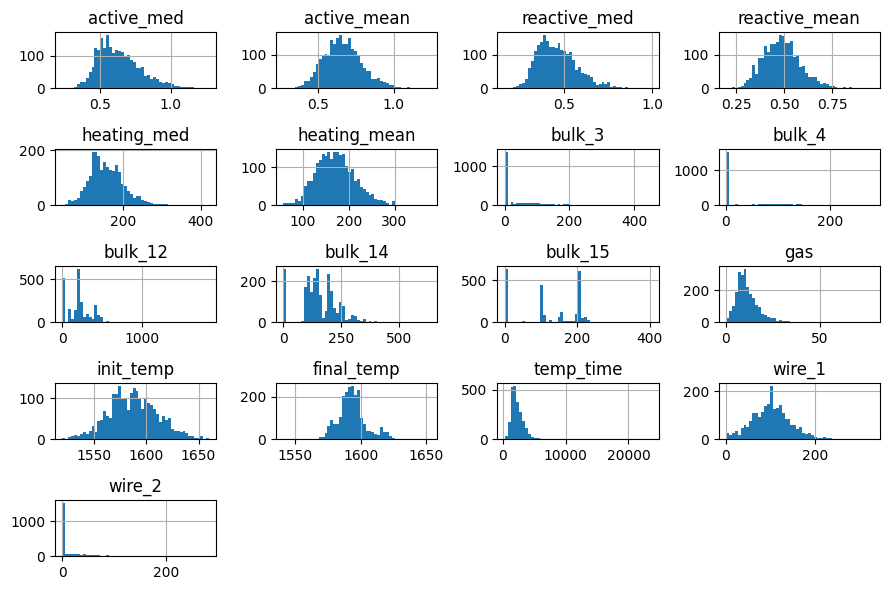

In [ ]:
display(df.describe())
df.hist(bins=50, figsize=(9, 6))
plt.tight_layout()
plt.show()

<Axes: >

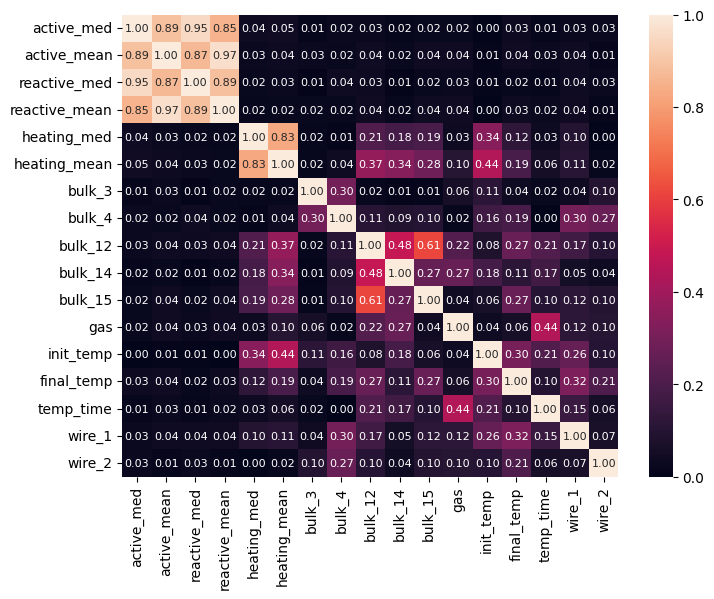

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr().abs(),
            vmin=0,
            annot=True,
            fmt='.2f',
            annot_kws={'fontsize': 8})

## Обучение моделей

In [ ]:
train, test = train_test_split(df, test_size=0.25, random_state=RNG_SEED)
print(train.shape)
print(test.shape)

(1746, 17)
(583, 17)


,active_med,active_mean,reactive_med,reactive_mean,heating_med,heating_mean,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,gas,init_temp,final_temp,temp_time,wire_1,wire_2
count,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000
mean,0.636919,0.665808,0.467307,0.490267,155.478236,171.160622,46.601947,37.607102,207.236541,152.540664,120.735395,11.371507,1587.623139,1593.544674,2336.269187,102.220428,17.411070
std,0.149761,0.126422,0.112459,0.096607,44.465918,43.546278,74.657477,59.071277,156.280376,81.045849,84.323717,6.406418,23.610910,11.342771,1444.188718,43.804214,33.687989
min,0.235282,0.267676,0.167425,0.196228,43.000000,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016696,1519.000000,1541.000000,270.000000,0.000000,0.000000
25%,0.526449,0.580868,0.384324,0.423490,125.000000,140.616667,0.000000,0.000000,106.000000,105.000000,0.000000,7.254013,1571.250000,1587.000000,1572.250000,73.148397,0.000000
50%,0.617312,0.659208,0.454371,0.486765,151.000000,168.775000,0.000000,0.000000,206.000000,147.000000,107.000000,10.145761,1587.000000,1593.000000,2050.500000,101.119202,0.000000
75%,0.724934,0.740852,0.533169,0.546338,183.000000,197.625000,79.000000,79.000000,268.000000,203.000000,204.000000,14.265485,1603.000000,1598.000000,2807.000000,127.155593,21.496540
max,1.268378,1.243889,0.995877,0.960763,421.000000,352.333333,454.000000,281.000000,1849.000000,636.000000,405.000000,77.995040,1660.000000,1647.000000,23674.000000,330.314424,282.780152


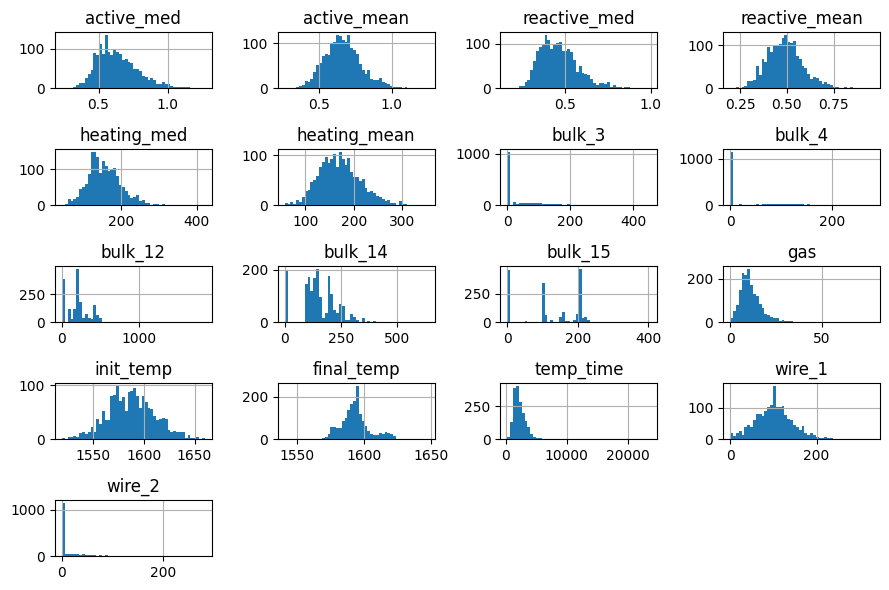

In [ ]:
display(train.describe())
train.hist(bins=50, figsize=(9, 6))
plt.tight_layout()
plt.show()

Чтобы уменьшить число выбросов, удаляем 0.1% крайних данных тренировочной выборки

(0.0005000000000000004, 0.9995)


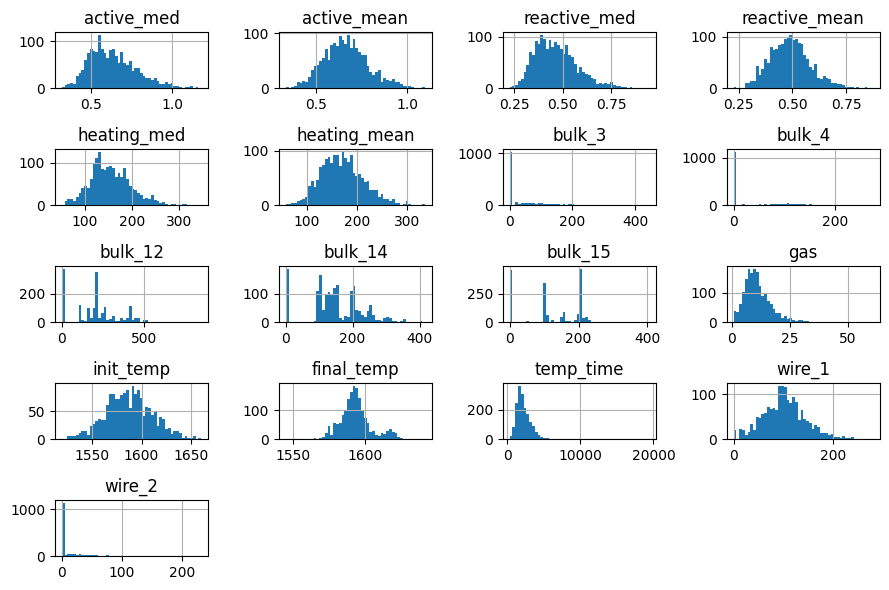

In [ ]:
frac = 0.999
a = (1 - frac) / 2
b = 1 - a
print((a, b))
train = train[(train >= train.quantile(a)) &
              (train <= train.quantile(b))].dropna()
train.hist(bins=50, figsize=(9, 6))
plt.tight_layout()
plt.show()

In [ ]:
train.shape

(1727, 17)

In [ ]:
xtrain = train.drop(['final_temp'], axis=1)
ytrain = train['final_temp']
xtest = test.drop(['final_temp'], axis=1)
ytest = test['final_temp']

In [ ]:
class Progress(tqdm):
    def __init__(self, total=None):
        super().__init__(total=total)
    def __call__(self, study, trial):
        self.update()
        self.set_postfix_str(
            f'Trial {trial.number}, MAE: {-trial.value:.2f}; '\
            f'Best: {study.best_trial.number}, MAE: {-study.best_value:.2f}'
        )

class EarlyStop:
    def __init__(self, threshold):
        self.threshold = threshold
    def __call__(self, study, trial):
        if trial.number - study.best_trial.number >= self.threshold:
            study.stop()

In [ ]:
best = type('', (), {'best_score_': float('-inf'), 'best_estimator_': None})()

In [ ]:
search = OptunaSearchCV(DecisionTreeRegressor(random_state=RNG_SEED),
                        {'max_depth': IntDistribution(1, 20),
                         'min_samples_split': IntDistribution(2, 10),
                         'min_samples_leaf': IntDistribution(1, 10),
                         'max_leaf_nodes': IntDistribution(2, 150)},
                        cv=3,
                        scoring='neg_mean_absolute_error',
                        random_state=RNG_SEED,
                        n_trials=100,
                        callbacks=[Progress(100), EarlyStop(20)])
search.fit(xtrain, ytrain)
print(f'params: {search.best_params_}')
print(f'MAE: {-search.best_score_:.2f}')
if search.best_score_ > best.best_score_:
    best = search

  0%|          | 0/100 [00:00<?, ?it/s]

params: {'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_leaf_nodes': 32}
MAE: 7.50


In [ ]:
search = OptunaSearchCV(RandomForestRegressor(random_state=RNG_SEED),
                        {'n_estimators': IntDistribution(1, 500),
                         'max_depth': IntDistribution(1, 20),
                         'min_samples_split': IntDistribution(2, 10),
                         'min_samples_leaf': IntDistribution(1, 10),
                         'max_leaf_nodes': IntDistribution(2, 150)},
                        cv=3,
                        scoring='neg_mean_absolute_error',
                        random_state=RNG_SEED,
                        n_trials=100,
                        callbacks=[Progress(100), EarlyStop(20)])
search.fit(xtrain, ytrain)
print(f'params: {search.best_params_}')
print(f'MAE: {-search.best_score_:.2f}')
if search.best_score_ > best.best_score_:
    best = search

  0%|          | 0/100 [00:00<?, ?it/s]

params: {'n_estimators': 447, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_leaf_nodes': 102}
MAE: 6.89


In [ ]:
search = OptunaSearchCV(CatBoostRegressor(random_state=RNG_SEED, verbose=0),
                        {'iterations': IntDistribution(1, 1000),
                         'learning_rate': FloatDistribution(0.01, 1, log=True),
                         'max_depth': IntDistribution(1, 6)},
                        cv=3,
                        scoring='neg_mean_absolute_error',
                        random_state=RNG_SEED,
                        n_trials=100,
                        callbacks=[Progress(100), EarlyStop(20)])
search.fit(xtrain, ytrain)
print(f'params: {search.best_params_}')
print(f'MAE: {-search.best_score_:.2f}')
if search.best_score_ > best.best_score_:
    best = search

  0%|          | 0/100 [00:00<?, ?it/s]

params: {'iterations': 398, 'learning_rate': 0.09012449868885648, 'max_depth': 2}
MAE: 6.68


## Проверка лучшей модели

In [ ]:
pred = best.best_estimator_.predict(xtest)
print(f'MAE: {mean_absolute_error(ytest, pred):.2f}')
print(f' R2: {r2_score(ytest, pred):.2f}')

MAE: 6.53
 R2: 0.35


Итого: Модель ошибается примерно на 6.5 °C. По R2 можно сказать что модель успешно объясняет примерно 35% данных.

In [ ]:
for s in ['mean', 'median']:
    print(f'Dummy {s.title()}')
    model = DummyRegressor(strategy=s)
    model.fit(xtrain, ytrain)
    pred = model.predict(xtest)
    print(f'MAE: {mean_absolute_error(ytest, pred):.2f}')
    print(f' R2: {r2_score(ytest, pred):.2f}')

Dummy Mean
MAE: 7.57
 R2: -0.00
Dummy Median
MAE: 7.50
 R2: -0.00


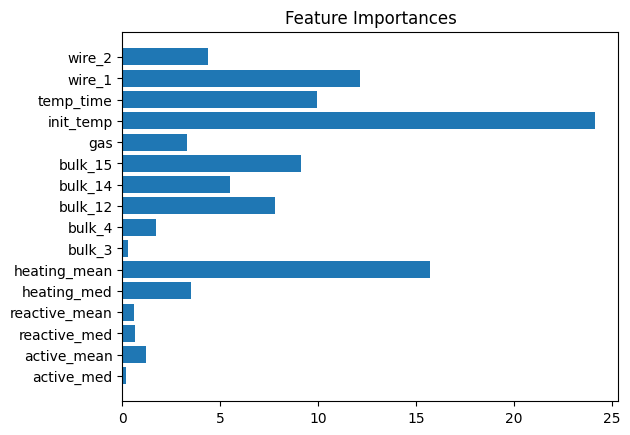

In [ ]:
plt.barh(xtrain.columns, best.best_estimator_.feature_importances_)
plt.title('Feature Importances')
plt.show()

Самыми важными признаками для моделирования оказались: начальная температура стали (`init_temp`) и среднее время нагрева дугой (`heating_mean`). Также можно выделить первый столбец данных о проволках (`wire_1`), время между первым и последни измерением температуры (`temp_time`), столбцы 15 и 12 данных о сыпучих материалах (`bulk_15` и `bulk_12`).

## Выводы

- Построены различные модели для предсказания итоговой температуры стали.
- Проведено тестирование лучшей модели
- Проанализирована важность признаков

## Отчёт

1. Все пункты плана были выполнены
1. Возникшие трудности:
    - Данных было достаточно много и в нескольких таблицах. Пришлось потратить некоторое время чтобы разобраться в структуре датасета и понять каким образом объединить таблицы.
    - Модели изначально переобучались из-за бага в коде предобработки. Потребовалось потратить довольно много времени на поиск и испраление этой ошибки.
1. Ключевых шаги решения:
    1. Исследовательский анализ данных
    1. Предобработка и объединение данных
    1. Обучение моделей и тестирование
1. Признаки использованые для обучения:
    1. `bulk_3`, `bulk_4`, `bulk_12`, `bulk_14`, `bulk_15` - данные о сыпучих материалах из файла `data_bulk_new.csv`. Столбцы с 80% пропусков и более, были удалены.
    1. `wire_1`, `wire_2` - данные о проволках из файла `data_wire_new.csv`. Столбцы с 80% пропусков и более, были удалены.
    1. `gas` - данные о продувке газом из файла `data_gas_new.csv`.
    1. `init_temp` и `final_temp` (целевой признак) - Начальная и итоговая температуры стали. Получены путём группировки данных из файла `data_temp_new.csv` по ключу (`key`) и выделению в каждой группе измерения температуры с самым ранним и самым поздним временем соответственно. Удалены температуры ниже 1500 °C и ключи с всего одним измерением.
    1. `temp_time` - время между первым и последним измерениями температуры в каждой группе. Методом `.dt.total_seconds()` переведено в секунды, тип `float`. Удалены ключи с всего одним измерением.
    1. `heating_mean`, `heating_med` - среднее и медиана времени нагрева дугой. Получены путём группировки данных файла `data_arc_new.csv` по ключу (`key`), вычислению разницы между концом и началом нагрева, и агрегации значений (вычисление среднего и медианы для каждого ключа). Методом `.dt.total_seconds()` переведены в секунды, тип `float`.
    1. `active_mean`, `active_mean` - среднее и медиана активной мощности для каждого ключа (`key`). Получены через агрегацию значений из файла `data_arc_new.csv`.
    1. `reactive_mean`, `reactive_mean` - среднее и медиана реактивной мощности для каждого ключа (`key`). Получены через агрегацию значений из файла `data_arc_new.csv`. Предварительно удалены отрицательные значения.
1. Лучшая полученная модель - `CatBoostRegressor` с параметрами: `random_state=310723, iterations=398, learning_rate=0.09012449868885648, max_depth=2`. Её MAE на тесте - 6.53.